In [1]:
from operator import itemgetter

import pandas as pd
import tqdm
import os

# Build CMV dataset with full conversations

In [ ]:
# load the data

cmv_path = r".\cmv_recsys-project.tsv"
df = pd.read_csv(cmv_path, sep='\t')
df.head()

In [3]:
# df["user_id"] = df["timestamp"]
# del df["timestamp"]
# df.head()

,conv_id,message_id,parent_id,content,cleaned_content,user_id
0,3,dq95b41,7f30fw,"Bitcoin gets hyped all the time here, and it's...","bitcoin gets hyped all the time here , and it'...",Bodoblock
1,3,dqa7q3h,dqa6myb,"Dude, unless you're actually reading financial...","dude , unless you're actually reading financia...",Bodoblock
2,3,dqafrpu,dqa6ckm,Biotechs with drugs in clinical trials are *al...,biotechs with drugs in clinical trials are * a...,DoodleVnTaintschtain
3,3,dqaow6z,dqaaaec,Why would anyone spend a currency that constan...,why would anyone spend a currency that constan...,Dopecheez-
4,3,dq9qql9,dq96i1n,We're really far from any kind of final Bubble...,we're really far from any kind of final bubble...,Experience111


### count users


In [ ]:
from collections import Counter

users_counts = df.groupby("user_id")["conv_id"].nunique()
users_counts.describe()

watch 10 most frequent users

In [ ]:
users_counts.nlargest(10)

## Filter irrelevant users
As we can see, the top 2 users are a mark for deleted users and a bot. We filter them.

In [6]:
ignore_mask = (df["user_id"] == "[deleted]") | (df["user_id"] == "DeltaBot")
ignore_df = df[ignore_mask]
df = df[~ignore_mask]

users_counts = df.groupby("user_id")["conv_id"].nunique()
users_counts.nlargest(5)

user_id
Ansuz07           1781
cdb03b            1239
PreacherJudge      989
Iswallowedafly     974
garnteller         887
Name: conv_id, dtype: int64

It is clear that most of the users occurs at most twice. But, we would like to have a compact dataset
that will have a distribution with users that participate a bit more in conversations. For this we group the users
by frequency and then sample randomly from each group of users.


In [7]:
import numpy as np

conv_user_df = df[["conv_id", "user_id"]].drop_duplicates()
conv_user_df["user_conv_count"] = conv_user_df["user_id"].map(users_counts.loc.__getitem__)
conv_user_df["user_conv_count_norm"] = np.minimum(conv_user_df["user_conv_count"], 10)
conv_user_df



,conv_id,user_id,user_conv_count,user_conv_count_norm
0,3,Bodoblock,38,10
2,3,DoodleVnTaintschtain,17,10
3,3,Dopecheez-,6,6
4,3,Experience111,3,3
6,3,Mtl325,12,10
...,...,...,...,...
674654,16301,tinyboat-,1,1
674657,16301,verronaut,22,10
674660,16304,MNGrrl,40,10
674666,16304,MystK,8,8


In [8]:
conv_groups = conv_user_df.groupby("conv_id")\
    .agg(
        n_users=("user_id", pd.Series.nunique),
        mean_user_counts=("user_conv_count_norm", "mean")
    )
conv_groups

,n_users,mean_user_counts
conv_id,,
3,32,6.343750
4,25,9.160000
5,32,7.000000
7,31,8.451613
12,24,8.291667
...,...,...
16298,9,8.444444
16299,15,9.066667
16300,28,8.714286


In [9]:
conv_groups.describe()

,n_users,mean_user_counts
count,8809.000000,8809.000000
mean,25.207856,8.186147
std,35.964517,1.126241
min,1.000000,1.000000
25%,11.000000,7.600000
50%,16.000000,8.363636
75%,26.000000,9.000000
max,674.000000,10.000000


In [10]:
sorted_conversations = conv_groups.sort_values(by="mean_user_counts", ascending=False)
sorted_conversations

,n_users,mean_user_counts
conv_id,,
6001,13,10.000000
6726,5,10.000000
510,9,10.000000
7154,8,10.000000
7083,7,10.000000
...,...,...
8347,1,3.000000
741,418,2.626794
15086,342,2.605263


In [11]:
conversation_sizes = df.groupby("conv_id").size().to_frame('size')
sorted_conversations_with_sizes = sorted_conversations.join(conversation_sizes)
sorted_conversations_with_sizes

,n_users,mean_user_counts,size
conv_id,,,
6001,13,10.000000,20
6726,5,10.000000,11
510,9,10.000000,10
7154,8,10.000000,25
7083,7,10.000000,15
...,...,...,...
8347,1,3.000000,10
741,418,2.626794,714
15086,342,2.605263,822


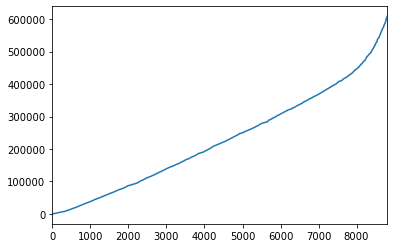

In [12]:
conversation_sizes = sorted_conversations_with_sizes["size"]
conversation_sizes.reset_index()["size"].cumsum().plot()

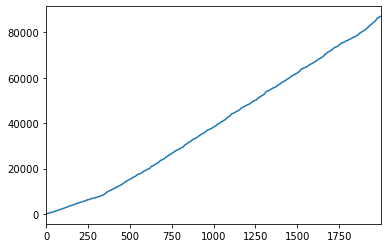

In [13]:
conversation_sizes[:2000].reset_index()["size"].cumsum().plot()

In [14]:
max_records = 50_000
selected_conversations = []
sum_records = 0
for index, size in sorted_conversations_with_sizes["size"].iteritems():
    selected_conversations.append(index)
    sum_records += size
    if sum_records >= max_records:
        break

print(f"number or records: {sum_records}")

number or records: 50007


convert selected conversations to set - it should be the same length as the list

In [15]:
print(f"number of selected conversations: {len(selected_conversations)}")
selected_conversations = set(selected_conversations)
print(f"number of unique selected conversations: {len(selected_conversations)}")

number of selected conversations: 1248
number of unique selected conversations: 1248


In [16]:
selected_df = df[df["conv_id"].isin(selected_conversations)]
print(f"number of items in data: {len(selected_df)}")
selected_df.head()

number of items in data: 50007


,conv_id,message_id,parent_id,content,cleaned_content,user_id
882,21,do6dyz3,75i1t3,The problem is you think of everything in too ...,the problem is you think of everything in too ...,-pom
883,21,do6pyq9,do6if7d,"Sorry fettoba, your comment has been removed: ...","sorry fettoba , your comment has been removed ...",Ansuz07
884,21,do6q0gq,75i1t3,"Sorry ehcaipf, your submission has been remove...","sorry ehcaipf , your submission has been remov...",Ansuz07
885,21,do6k0mz,75i1t3,"I mean, one might say that in a perfect world,...","i mean , one might say that in a perfect world...",BroccoliManChild
886,21,do6hilj,75i1t3,"You sound like they guy who says ""I don't get ...","you sound like they guy who says "" i don't get...",Burflax


In [17]:
new_users_counts = selected_df.groupby("user_id")["conv_id"].nunique()
new_users_counts.describe()

count    3653.000000
mean        4.712291
std        12.031706
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       268.000000
Name: conv_id, dtype: float64

In [18]:
new_users_counts.nlargest(10)

user_id
Ansuz07            268
PreacherJudge      168
cdb03b             167
Iswallowedafly     165
cacheflow          142
GnosticGnome       140
Huntingmoa         125
garnteller         121
Glory2Hypnotoad    119
Ardonpitt          118
Name: conv_id, dtype: int64

## reset conversation ids

In [19]:
conversation_ids_mapping = {conv_id: i for i, conv_id in enumerate(sorted(selected_conversations))}
new_conv_ids = selected_df["conv_id"].map(conversation_ids_mapping.get)
selected_df["conv_id"] = new_conv_ids
selected_df.head()

c:\users\ronp\py37-dasci\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,conv_id,message_id,parent_id,content,cleaned_content,user_id
882,0,do6dyz3,75i1t3,The problem is you think of everything in too ...,the problem is you think of everything in too ...,-pom
883,0,do6pyq9,do6if7d,"Sorry fettoba, your comment has been removed: ...","sorry fettoba , your comment has been removed ...",Ansuz07
884,0,do6q0gq,75i1t3,"Sorry ehcaipf, your submission has been remove...","sorry ehcaipf , your submission has been remov...",Ansuz07
885,0,do6k0mz,75i1t3,"I mean, one might say that in a perfect world,...","i mean , one might say that in a perfect world...",BroccoliManChild
886,0,do6hilj,75i1t3,"You sound like they guy who says ""I don't get ...","you sound like they guy who says "" i don't get...",Burflax


## reset users ids

In [20]:
user_ids_mapping = {user_id: i for i, user_id in enumerate(sorted(selected_df["user_id"]))}
new_user_ids = selected_df["user_id"].map(user_ids_mapping.get)
selected_df["user_id"] = new_user_ids
selected_df.head()

c:\users\ronp\py37-dasci\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,conv_id,message_id,parent_id,content,cleaned_content,user_id
882,0,do6dyz3,75i1t3,The problem is you think of everything in too ...,the problem is you think of everything in too ...,323
883,0,do6pyq9,do6if7d,"Sorry fettoba, your comment has been removed: ...","sorry fettoba , your comment has been removed ...",2533
884,0,do6q0gq,75i1t3,"Sorry ehcaipf, your submission has been remove...","sorry ehcaipf , your submission has been remov...",2533
885,0,do6k0mz,75i1t3,"I mean, one might say that in a perfect world,...","i mean , one might say that in a perfect world...",4670
886,0,do6hilj,75i1t3,"You sound like they guy who says ""I don't get ...","you sound like they guy who says "" i don't get...",4931


In [21]:
# verify that no index was skipped
list(selected_df["conv_id"].unique()) == list(range(len(selected_conversations)))

True

In [22]:
selected_df.to_csv("cmv-frequent-recsys.tsv", sep="\t", index=False)

# Build CMV Dataset with Random Branches
(Not full conversations)
use the same selected conversations to pick branches

In [29]:
original_df = selected_df.append(ignore_df)
message_id_index_mapping = original_df["message_id"].reset_index().set_index("message_id")
selected_nodes_df = selected_df.sample(n=15000, random_state=1919)
parents_rows = {}
for index, row in tqdm.tqdm(selected_nodes_df.iterrows(), total=len(selected_nodes_df)):
    index_in_conv = 0
    conv_id = row.conv_id
    parents_rows[(conv_id, index_in_conv)] = row
    parent_id = row.parent_id

    while (not pd.isna(parent_id)) and (parent_id is not None) and (parent_id != "None"):
        index_in_conv -= 1
        parent_index = message_id_index_mapping.loc[parent_id]["index"]
        parent_row = original_df.loc[parent_index]
        parent_id = parent_row.parent_id
        # random_df.loc[parent_index] = parent_row
        parents_rows[(conv_id, index_in_conv)] = parent_row

selected_branches_df = pd.concat(map(itemgetter(1), sorted(parents_rows.items(), key=itemgetter(0))), axis=1).T
print(f"total number of record: {len(selected_branches_df)}")
selected_branches_df.head()

100%|██████████| 15000/15000 [01:21<00:00, 183.15it/s]


total number of record: 11240


,conv_id,message_id,parent_id,content,cleaned_content,user_id
928,0,75i1t3,None,[removed],[ removed ],34043
925,0,do6b85m,75i1t3,Weinstein **doesn't** grant favors to women in...,weinstein * <REPEAT> doesn't * <REPEAT> grant ...,33662
928,0,75i1t3,None,[removed],[ removed ],34043
925,0,do6b85m,75i1t3,Weinstein **doesn't** grant favors to women in...,weinstein * <REPEAT> doesn't * <REPEAT> grant ...,33662
929,0,do6bc58,do6b85m,Has any women who refused been black listed? A...,has any women who refused been black listed ? ...,34043


number of conversations

In [40]:
len(selected_conversations)

1248

In [ ]:
selected_branches_df["conv_id"].nunique()

In [31]:
new_users_counts = selected_branches_df.groupby("user_id")["conv_id"].nunique()
new_users_counts.describe()

count    1652.000000
mean        2.446731
std        10.523727
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       404.000000
Name: conv_id, dtype: float64

In [32]:
new_users_counts.nlargest(10)

user_id
[deleted]    404
32414         46
20315         44
2533          40
30438         39
12891         36
11757         34
10032         33
31172         32
3040          24
Name: conv_id, dtype: int64

## reset conversation ids

In [33]:
conversations = sorted(selected_branches_df["conv_id"].unique())
conversation_ids_mapping = {conv_id: i for i, conv_id in enumerate(conversations)}
new_conv_ids = selected_branches_df["conv_id"].map(conversation_ids_mapping.get)
selected_branches_df["conv_id"] = new_conv_ids
selected_branches_df.head()

,conv_id,message_id,parent_id,content,cleaned_content,user_id
928,0,75i1t3,None,[removed],[ removed ],34043
925,0,do6b85m,75i1t3,Weinstein **doesn't** grant favors to women in...,weinstein * <REPEAT> doesn't * <REPEAT> grant ...,33662
928,0,75i1t3,None,[removed],[ removed ],34043
925,0,do6b85m,75i1t3,Weinstein **doesn't** grant favors to women in...,weinstein * <REPEAT> doesn't * <REPEAT> grant ...,33662
929,0,do6bc58,do6b85m,Has any women who refused been black listed? A...,has any women who refused been black listed ? ...,34043


## reset users ids

In [38]:
selected_branches_df["user_id"] = [u if (u != "[deleted]" and u != "DeltaBot") else -1 for u in selected_branches_df["user_id"]]
user_ids_mapping = {user_id: i for i, user_id in enumerate(sorted(selected_branches_df["user_id"]))}
user_ids_mapping["[deleted]"] = -1
user_ids_mapping["DeltaBot"] = -1
new_user_ids = selected_branches_df["user_id"].map(user_ids_mapping.get)
selected_branches_df["user_id"] = new_user_ids
selected_branches_df.head()

,conv_id,message_id,parent_id,content,cleaned_content,user_id
928,0,75i1t3,None,[removed],[ removed ],8090
925,0,do6b85m,75i1t3,Weinstein **doesn't** grant favors to women in...,weinstein * <REPEAT> doesn't * <REPEAT> grant ...,8006
928,0,75i1t3,None,[removed],[ removed ],8090
925,0,do6b85m,75i1t3,Weinstein **doesn't** grant favors to women in...,weinstein * <REPEAT> doesn't * <REPEAT> grant ...,8006
929,0,do6bc58,do6b85m,Has any women who refused been black listed? A...,has any women who refused been black listed ? ...,8090


## write to csv

In [39]:
selected_branches_df.to_csv("cmv-selected-branches-recsys.tsv", sep="\t", index=False)

